# Case Study

Jack Dean, Charles Dotson, and Rodrigo Petricioli  
ISE 447 - Financial Optimization  
Lehigh Univerisity

In [1]:
'''
Package Imports
'''
import pandas as pd
import numpy as np
import pulp
from pulp import *
import datetime
import matplotlib.pyplot as plt

import FinOpsCodeDeck as finops

from IPython.display import Markdown as md
# %matplotlib widget

## Provided Data

A municipality sends the following liability stream (in millions of dollars)

| Date Due | Amount |  
| -- | -- |
| 12/15/2022 | 11 |  
|  6/15/2023 |  9 |  
| 12/15/2023 |  8 |  
|  6/15/2024 |  7 |  
| 12/15/2024 |  9 |  
|  6/15/2025 | 10 |  
| 12/15/2025 |  9 |  
|  6/15/2026 | 12 |  
| 12/15/2026 |  9 |  
|  6/15/2027 |  6 |  
| 12/15/2027 |  5 |  
|  6/15/2028 |  7 |  
| 12/15/2028 |  9 |  
|  6/15/2029 |  7 |  
| 12/15/2029 |  8 |  
|  6/15/2030 |  7 |  

## Problem 1

Determine the current term structure of treasury rates (see textbook Section 3.4 or other resources that you can find), and find the present value, duration, and convexity of the stream of liabilities. Please explain the main steps followed in your calculations.  Use real world data.

In [2]:
'''
Data Import for Current Term Structure
---
Imports all active treasury bonds data, time indexes them by year
'''
data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt = data_prompt/1000
term_structure_df = pd.read_excel('Table.xlsx', sheet_name='Bills Bonds and Notes')
term_structure_df['px_last'] = [i if i>=5 else 100 - i for i in term_structure_df['ASKED'].to_list()]
term_structure_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in term_structure_df['MATURITY']]

In [3]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in term_structure_df[term_structure_df['ttm'] <= 0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    cpn = bond['COUPON']/2
    ttm = bond['ttm']
    px = bond['px_last']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_last']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in term_structure_df[term_structure_df['ttm']>=0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    px = bond['px_last']
    ttm = bond['ttm']
    cpn = bond['COUPON']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

Text(0, 0.5, 'Yield in Percentage Points')

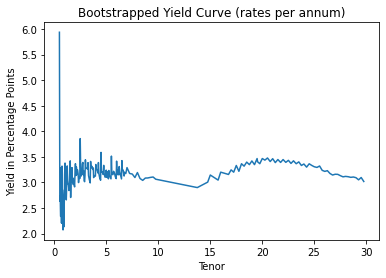

In [4]:
'''
plot yield curve
---
plots yield curve in percentage points
'''
plt.plot(rates[0.5:] * 100)
plt.title('Bootstrapped Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')

In [5]:
data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt['ttm'] = np.round((data_prompt.index - datetime.datetime.now()) / datetime.timedelta(days=365), round_to)

r = []
for ttm in data_prompt['ttm']:
    r.append(rates[:ttm].iloc[-1,0])
data_prompt['rates'] = r

npv = sum([data_prompt.iloc[i,0]*np.exp((-1) * data_prompt.iloc[i,1] * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
dur = sum([data_prompt.iloc[i,1]*data_prompt.iloc[i,0]*np.exp((-1) * data_prompt.iloc[i,1] * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
con = sum([data_prompt.iloc[i,1]*(data_prompt.iloc[i,1]+1)*data_prompt.iloc[i,0]*np.exp((-1) * (data_prompt.iloc[i,1] + 2 ) * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])

print('The Net Present Value of the Liabilities is ${:.2f} million dollars'.format(npv/1000))
print('The Macauley Duration of the Liability stream is {:.2f} years'.format(dur/npv))
print('The Convexity of the Liability stream is {:.2f}'.format(con/npv))

The Net Present Value of the Liabilities is $116.94 million dollars
The Macauley Duration of the Liability stream is 3.95 years
The Convexity of the Liability stream is 23.28


In [6]:
# Using markdown outputs instead of just printing

md('''
<center>

### Solutions

The Net Present Value of the Liabilities is $\${:.2f}$ MM

The Macauley Duration of the Liability stream is ${:.2f}$ years

The Convexity of the Liability stream is ${:.2f}$


'''.format(npv/1000,dur/npv,con/npv))



<center>

### Solutions

The Net Present Value of the Liabilities is $\$116.94$ MM

The Macauley Duration of the Liability stream is $3.95$ years

The Convexity of the Liability stream is $23.28$




## Problem 2

Identify *at least* 30 fixed-income assets that are suitable to construct a dedicated bond portfolio for the municipality liabilities that you have been given. Use assets that are considered risk-free; for example, US government non-callable treasury bonds, treasury bills, or treasury notes. Display in an appropriate table the main characteristics of the bonds you choose. Namely, prices, coupon rates, maturity dates, face value).

In [7]:
'''
code block
'''
ref_data = ['T ' + str(term_structure_df.iloc[bond,1]) + ' ' + term_structure_df.iloc[bond,0].strftime('%m/%d/%y') for bond in term_structure_df.index]
term_structure_df['ref_data'] = ref_data

bonds_clean = term_structure_df[['ref_data', 'px_last', 'ASKED YIELD']]
bonds_clean.columns = ['Bond', 'Price', 'Yield']
# bonds_clean = bonds_clean.assign(ttm = term_structure_df.ttm.round(2))
bonds_clean = bonds_clean.set_index('Bond')

In [8]:
# You cannot tabe anything within the string literal for the markdown output, See the cell titled "BAD MARKDOWN OUTPUT"
# Also when we finally convert to PDF I plan on using the metadata and hiding the markdown output cell because it takes up to much space and is ugly
# Because of this, have all output cells in their own cell as done here
md('''
<center>

{}

    
'''.format(bonds_clean.to_markdown(colalign = ("center",)))
)


<center>

|       Bond       |   Price |   Yield |
|:----------------:|--------:|--------:|
|  T 0.0 05/05/22  |  99.942 |  0.058  |
|  T 0.0 05/10/22  |  99.925 |  0.076  |
|  T 0.0 05/12/22  |  99.857 |  0.145  |
| T 1.75 05/15/22  | 100.024 | -0.6005 |
| T 2.125 05/15/22 | 100.03  | -0.6944 |
|  T 0.0 05/17/22  |  99.815 |  0.188  |
|  T 0.0 05/19/22  |  99.762 |  0.241  |
|  T 0.0 05/24/22  |  99.68  |  0.325  |
|  T 0.0 05/26/22  |  99.675 |  0.33   |
|  T 0.0 05/31/22  |  99.63  |  0.375  |
| T 0.125 05/31/22 | 100     |  0.125  |
| T 1.75 05/31/22  | 100.04  |  0.124  |
| T 1.875 05/31/22 | 100.034 |  0.45   |
|  T 0.0 06/02/22  |  99.665 |  0.34   |
|  T 0.0 06/07/22  |  99.597 |  0.408  |
|  T 0.0 06/09/22  |  99.595 |  0.411  |
|  T 0.0 06/14/22  |  99.577 |  0.429  |
| T 1.75 06/15/22  | 100.046 |  0.49   |
|  T 0.0 06/16/22  |  99.582 |  0.424  |
|  T 0.0 06/21/22  |  99.48  |  0.528  |
|  T 0.0 06/23/22  |  99.5   |  0.507  |
|  T 0.0 06/28/22  |  99.337 |  0.672  |
|  T 0.0 06/30/22  |  99.35  |  0.66   |
| T 0.125 06/30/22 |  99.292 |  0.662  |
| T 1.75 06/30/22  | 100.056 |  0.624  |
| T 2.125 06/30/22 | 100.076 |  0.608  |
|  T 0.0 07/07/22  |  99.29  |  0.721  |
|  T 0.0 07/14/22  |  99.262 |  0.749  |
| T 1.75 07/15/22  | 100.062 |  0.777  |
|  T 0.0 07/21/22  |  99.232 |  0.78   |
|  T 0.0 07/28/22  |  99.212 |  0.8    |
| T 0.125 07/31/22 |  99.264 |  0.826  |
| T 1.875 07/31/22 | 100.082 |  0.821  |
|  T 2.0 07/31/22  | 100.092 |  0.819  |
|  T 0.0 08/04/22  |  99.112 |  0.902  |
|  T 0.0 08/11/22  |  99.055 |  0.961  |
|  T 1.5 08/15/22  | 100.05  |  0.953  |
| T 1.625 08/15/22 | 100.062 |  0.941  |
| T 7.25 08/15/22  | 101.244 |  1.07   |
|  T 0.0 08/18/22  |  99.047 |  0.969  |
|  T 0.0 08/25/22  |  98.972 |  1.045  |
| T 0.125 08/31/22 |  99.222 |  1.063  |
| T 1.625 08/31/22 | 100.054 |  1.094  |
| T 1.875 08/31/22 | 100.082 |  1.079  |
|  T 0.0 09/01/22  |  98.927 |  1.091  |
|  T 0.0 09/08/22  |  98.93  |  1.089  |
|  T 0.0 09/15/22  |  98.912 |  1.107  |
|  T 1.5 09/15/22  | 100.042 |  1.135  |
|  T 0.0 09/22/22  |  98.927 |  1.092  |
|  T 0.0 09/29/22  |  98.89  |  1.131  |
| T 0.125 09/30/22 |  99.176 |  1.218  |
| T 1.75 09/30/22  | 100.064 |  1.251  |
| T 1.875 09/30/22 | 100.082 |  1.241  |
|  T 0.0 10/06/22  |  98.85  |  1.172  |
|  T 0.0 10/13/22  |  98.742 |  1.282  |
| T 1.375 10/15/22 | 100.004 |  1.34   |
|  T 0.0 10/20/22  |  98.72  |  1.306  |
|  T 0.0 10/27/22  |  98.625 |  1.404  |
| T 0.125 10/31/22 |  99.12  |  1.405  |
| T 1.875 10/31/22 | 100.072 |  1.411  |
|  T 2.0 10/31/22  | 100.094 |  1.392  |
|  T 0.0 11/03/22  |  98.637 |  1.391  |
| T 1.625 11/15/22 | 100.022 |  1.492  |
| T 7.625 11/15/22 | 103.06  |  1.595  |
| T 0.125 11/30/22 |  99.06  |  1.545  |
|  T 2.0 11/30/22  | 100.082 |  1.549  |
|  T 0.0 12/01/22  |  98.607 |  1.424  |
| T 1.625 12/15/22 | 100.004 |  1.599  |
|  T 0.0 12/29/22  |  98.54  |  1.495  |
| T 0.137 12/31/22 |  98.306 |  1.714  |
| T 2.125 12/31/22 | 100.09  |  1.693  |
|  T 1.5 01/15/23  |  99.266 |  1.735  |
|  T 0.0 01/26/23  |  98.447 |  1.593  |
| T 0.125 01/31/23 |  98.244 |  1.798  |
| T 1.75 01/31/23  |  99.31  |  1.791  |
| T 2.375 01/31/23 | 100.132 |  1.812  |
| T 1.375 02/15/23 |  99.204 |  1.836  |
|  T 2.0 02/15/23  | 100.036 |  1.848  |
| T 7.125 02/15/23 | 104.036 |  1.829  |
|  T 0.0 02/23/23  |  98.3   |  1.748  |
| T 0.125 02/28/23 |  98.166 |  1.935  |
|  T 1.5 02/28/23  |  99.21  |  1.92   |
| T 2.625 02/28/23 | 100.176 |  1.943  |
|  T 0.5 03/15/23  |  98.242 |  1.952  |
|  T 0.0 03/23/23  |  98.235 |  1.823  |
| T 0.125 03/31/23 |  98.094 |  2.024  |
|  T 1.5 03/31/23  |  99.174 |  2.005  |
|  T 2.5 03/31/23  | 100.126 |  2.055  |
| T 0.25 04/15/23  |  98.084 |  2.102  |
|  T 0.0 04/20/23  |  98.017 |  2.05   |
| T 0.125 04/30/23 |  98.006 |  2.15   |
| T 1.625 04/30/23 |  99.154 |  2.153  |
| T 2.75 04/30/23  | 100.186 |  2.15   |
| T 0.125 05/15/23 |  97.292 |  2.178  |
| T 1.75 05/15/23  |  99.182 |  2.173  |
| T 0.125 05/31/23 |  97.256 |  2.199  |
| T 1.625 05/31/23 |  99.116 |  2.222  |
| T 2.75 05/31/23  | 100.18  |  2.218  |
| T 0.25 06/15/23  |  97.262 |  2.235  |
| T 0.125 06/30/23 |  97.174 |  2.279  |
| T 1.375 06/30/23 |  98.31  |  2.28   |
| T 2.625 06/30/23 | 100.124 |  2.281  |
| T 0.125 07/15/23 |  97.122 |  2.347  |
| T 0.125 07/31/23 |  97.074 |  2.391  |
| T 1.25 07/31/23  |  98.204 |  2.363  |
| T 2.75 07/31/23  | 100.14  |  2.39   |
| T 0.125 08/15/23 |  97.04  |  2.407  |
|  T 2.5 08/15/23  | 100.046 |  2.381  |
| T 6.25 08/15/23  | 104.292 |  2.349  |
| T 0.125 08/31/23 |  96.306 |  2.469  |
| T 1.375 08/31/23 |  98.2   |  2.434  |
| T 2.75 08/31/23  | 100.126 |  2.441  |
| T 0.125 09/15/23 |  96.284 |  2.452  |
| T 0.25 09/30/23  |  96.302 |  2.468  |
| T 1.375 09/30/23 |  98.164 |  2.452  |
| T 2.875 09/30/23 | 100.17  |  2.488  |
| T 0.125 10/15/23 |  96.202 |  2.503  |
| T 0.375 10/31/23 |  96.272 |  2.539  |
| T 1.625 10/31/23 |  98.226 |  2.511  |
| T 2.875 10/31/23 | 100.154 |  2.542  |
| T 0.25 11/15/23  |  96.174 |  2.561  |
| T 2.75 11/15/23  | 100.096 |  2.546  |
|  T 0.5 11/30/23  |  96.25  |  2.596  |
| T 2.125 11/30/23 |  99.106 |  2.557  |
| T 2.875 11/30/23 | 100.144 |  2.579  |
| T 0.125 12/15/23 |  96.034 |  2.596  |
| T 0.75 12/31/23  |  96.302 |  2.642  |
| T 2.25 12/31/23  |  99.134 |  2.607  |
| T 2.625 12/31/23 | 100.014 |  2.595  |
| T 0.125 01/15/24 |  95.272 |  2.634  |
| T 0.875 01/31/24 |  96.31  |  2.663  |
|  T 2.5 01/31/24  |  99.234 |  2.656  |
| T 0.125 02/15/24 |  95.194 |  2.657  |
| T 2.75 02/15/24  | 100.05  |  2.659  |
|  T 1.5 02/29/24  |  97.294 |  2.673  |
| T 2.125 02/29/24 |  99.012 |  2.667  |
| T 2.375 02/29/24 |  99.152 |  2.67   |
| T 0.25 03/15/24  |  95.184 |  2.695  |
| T 2.125 03/31/24 |  98.294 |  2.708  |
| T 2.25 03/31/24  |  99.046 |  2.71   |
| T 0.375 04/15/24 |  95.184 |  2.718  |
|  T 2.0 04/30/24  |  98.194 |  2.722  |
| T 2.25 04/30/24  |  99.032 |  2.716  |
|  T 2.5 04/30/24  |  99.184 |  2.719  |
| T 0.25 05/15/24  |  95.032 |  2.744  |
|  T 2.5 05/15/24  |  99.154 |  2.762  |
|  T 2.0 05/31/24  |  98.16  |  2.748  |
| T 0.25 06/15/24  |  94.264 |  2.781  |
| T 1.75 06/30/24  |  97.276 |  2.773  |
|  T 2.0 06/30/24  |  98.11  |  2.795  |
| T 0.375 07/15/24 |  94.266 |  2.81   |
| T 1.75 07/31/24  |  97.226 |  2.808  |
| T 2.125 07/31/24 |  98.162 |  2.814  |
| T 0.375 08/15/24 |  94.182 |  2.844  |
| T 2.375 08/15/24 |  98.296 |  2.861  |
| T 1.25 08/31/24  |  96.136 |  2.847  |
| T 1.875 08/31/24 |  97.256 |  2.857  |
| T 0.375 09/15/24 |  94.102 |  2.874  |
|  T 1.5 09/30/24  |  96.272 |  2.861  |
| T 2.125 09/30/24 |  98.094 |  2.861  |
| T 0.625 10/15/24 |  94.226 |  2.866  |
|  T 1.5 10/31/24  |  96.216 |  2.891  |
| T 2.25 10/31/24  |  98.146 |  2.895  |
| T 0.75 11/15/24  |  94.244 |  2.907  |
| T 2.25 11/15/24  |  98.132 |  2.904  |
|  T 7.5 11/15/24  | 111.11  |  2.827  |
|  T 1.5 11/30/24  |  96.176 |  2.897  |
| T 2.125 11/30/24 |  98.026 |  2.901  |
|  T 1.0 12/15/24  |  95.08  |  2.894  |
| T 1.75 12/31/24  |  97.012 |  2.914  |
| T 2.25 12/31/24  |  98.102 |  2.91   |
| T 1.125 01/15/25 |  95.116 |  2.92   |
| T 1.375 01/31/25 |  95.304 |  2.919  |
|  T 2.5 01/31/25  |  98.294 |  2.911  |
|  T 1.5 02/15/25  |  96.052 |  2.941  |
|  T 2.0 02/15/25  |  97.174 |  2.922  |
| T 7.625 02/15/25 | 112.216 |  2.857  |
| T 1.125 02/28/25 |  95.052 |  2.92   |
| T 2.75 02/28/25  |  99.17  |  2.923  |
| T 1.75 03/15/25  |  96.246 |  2.931  |
|  T 0.5 03/31/25  |  93.086 |  2.928  |
| T 2.625 03/31/25 |  99.044 |  2.935  |
| T 2.625 04/15/25 |  99.054 |  2.92   |
| T 0.375 04/30/25 |  92.224 |  2.941  |
| T 2.875 04/30/25 |  99.262 |  2.938  |
| T 2.125 05/15/25 |  97.2   |  2.949  |
| T 0.25 05/31/25  |  92.032 |  2.954  |
| T 2.875 05/31/25 |  99.252 |  2.947  |
| T 0.25 06/30/25  |  91.276 |  2.965  |
| T 2.75 06/30/25  |  99.124 |  2.953  |
| T 0.25 07/31/25  |  91.2   |  2.976  |
| T 2.875 07/31/25 |  99.234 |  2.961  |
|  T 2.0 08/15/25  |  96.306 |  2.977  |
| T 6.875 08/15/25 | 112.102 |  2.916  |
| T 0.25 08/31/25  |  91.132 |  2.981  |
| T 2.75 08/31/25  |  99.094 |  2.973  |
| T 0.25 09/30/25  |  91.062 |  2.985  |
|  T 3.0 09/30/25  | 100.03  |  2.97   |
| T 0.25 10/31/25  |  91.002 |  2.981  |
|  T 3.0 10/31/25  | 100.026 |  2.974  |
| T 2.25 11/15/25  |  97.174 |  2.987  |
| T 0.375 11/30/25 |  91.054 |  2.996  |
| T 2.875 11/30/25 |  99.196 |  2.988  |
| T 0.375 12/31/25 |  90.316 |  2.991  |
| T 2.625 12/31/25 |  98.244 |  2.983  |
| T 0.375 01/31/26 |  90.24  |  3.004  |
| T 2.625 01/31/26 |  98.224 |  2.993  |
| T 1.625 02/15/26 |  95.026 |  3.007  |
|  T 6.0 02/15/26  | 110.244 |  2.972  |
|  T 0.5 02/28/26  |  91.002 |  3.005  |
|  T 2.5 02/28/26  |  98.066 |  2.998  |
| T 0.75 03/31/26  |  91.232 |  3.009  |
| T 2.25 03/31/26  |  97.076 |  3.003  |
| T 0.75 04/30/26  |  91.182 |  3.007  |
| T 2.375 04/30/26 |  97.214 |  2.998  |
| T 1.625 05/15/26 |  94.246 |  3.011  |
| T 0.75 05/31/26  |  91.116 |  3.016  |
| T 2.125 05/31/26 |  96.202 |  3.009  |
| T 0.875 06/30/26 |  91.214 |  3.02   |
| T 1.875 06/30/26 |  95.204 |  2.997  |
| T 0.625 07/31/26 |  90.162 |  3.024  |
| T 1.875 07/31/26 |  95.18  |  2.995  |
|  T 1.5 08/15/26  |  93.29  |  3.026  |
| T 6.75 08/15/26  | 114.296 |  3.011  |
| T 0.75 08/31/26  |  90.272 |  3.022  |
| T 1.375 08/31/26 |  93.12  |  3.02   |
| T 0.875 09/30/26 |  91.06  |  3.025  |
| T 1.625 09/30/26 |  94.082 |  3.026  |
| T 1.125 10/31/26 |  92.022 |  3.026  |
| T 1.625 10/31/26 |  94.05  |  3.026  |
|  T 2.0 11/15/26  |  95.196 |  3.042  |
|  T 6.5 11/15/26  | 114.194 |  3.026  |
| T 1.25 11/30/26  |  92.164 |  3.013  |
| T 1.625 11/30/26 |  94.024 |  3.02   |
| T 1.25 12/31/26  |  92.112 |  3.022  |
| T 1.75 12/31/26  |  94.166 |  3.018  |
|  T 1.5 01/31/27  |  93.096 |  3.025  |
| T 2.25 02/15/27  |  96.172 |  3.032  |
| T 6.625 02/15/27 | 115.28  |  3.036  |
| T 1.125 02/28/27 |  91.174 |  3.02   |
| T 1.875 02/28/27 |  94.302 |  3.008  |
| T 0.625 03/31/27 |  89.044 |  3.021  |
|  T 2.5 03/31/27  |  97.212 |  3.015  |
|  T 0.5 04/30/27  |  88.124 |  3.023  |
| T 2.75 04/30/27  |  98.26  |  3.008  |
| T 2.375 05/15/27 |  97     |  3.022  |
|  T 0.5 05/31/27  |  88.036 |  3.044  |
|  T 0.5 06/30/27  |  87.304 |  3.04   |
| T 0.375 07/31/27 |  87.084 |  3.018  |
| T 2.25 08/15/27  |  96.042 |  3.047  |
| T 6.375 08/15/27 | 116.06  |  3.037  |
|  T 0.5 08/31/27  |  87.176 |  3.049  |
|  T 0.5 10/31/27  |  87.062 |  3.05   |
| T 2.25 11/15/27  |  95.312 |  3.046  |
| T 6.125 11/15/27 | 115.18  |  3.047  |
| T 0.625 11/30/27 |  87.2   |  3.055  |
| T 0.625 12/31/27 |  87.142 |  3.057  |
| T 0.75 01/31/28  |  87.29  |  3.061  |
| T 2.75 02/15/28  |  98.126 |  3.054  |
| T 1.125 02/29/28 |  89.256 |  3.048  |
| T 1.25 03/31/28  |  90.086 |  3.062  |
| T 1.25 04/30/28  |  90.046 |  3.062  |
| T 2.875 05/15/28 |  98.304 |  3.066  |
| T 1.25 05/31/28  |  90     |  3.066  |
| T 1.25 06/30/28  |  89.272 |  3.071  |
|  T 1.0 07/31/28  |  88.096 |  3.072  |
| T 2.875 08/15/28 |  98.286 |  3.069  |
|  T 5.5 08/15/28  | 113.294 |  3.049  |
| T 1.125 08/31/28 |  88.284 |  3.07   |
| T 1.25 09/30/28  |  89.142 |  3.077  |
| T 1.375 10/31/28 |  90.022 |  3.074  |
| T 3.125 11/15/28 | 100.12  |  3.061  |
| T 5.25 11/15/28  | 112.316 |  3.042  |
|  T 1.5 11/30/28  |  90.226 |  3.07   |
| T 1.375 12/31/28 |  89.296 |  3.058  |
| T 1.75 01/31/29  |  92.024 |  3.058  |
| T 2.625 02/15/29 |  97.13  |  3.051  |
| T 5.25 02/15/29  | 113.144 |  3.041  |
| T 1.875 02/28/29 |  92.264 |  3.046  |
| T 2.375 03/31/29 |  95.256 |  3.053  |
| T 2.375 05/15/29 |  95.252 |  3.045  |
| T 1.625 08/15/29 |  90.294 |  3.022  |
| T 6.125 08/15/29 | 120.1   |  3      |
| T 1.75 11/15/29  |  91.182 |  3.009  |
|  T 1.5 02/15/30  |  89.186 |  3.01   |
| T 0.625 05/15/30 |  83.024 |  3.012  |
| T 6.25 05/15/30  | 123.066 |  2.98   |
| T 0.625 08/15/30 |  82.204 |  3.007  |
| T 0.875 11/15/30 |  84.036 |  2.998  |
| T 1.125 02/15/31 |  85.21  |  2.993  |
| T 5.375 02/15/31 | 118.146 |  2.972  |
| T 1.625 05/15/31 |  89.072 |  2.995  |
| T 1.25 08/15/31  |  85.302 |  2.995  |
| T 1.375 11/15/31 |  86.204 |  2.996  |
| T 1.875 02/15/32 |  90.182 |  2.994  |
|  T 4.5 02/15/36  | 118.086 |  2.884  |
| T 4.75 02/15/37  | 121.08  |  2.964  |
|  T 5.0 05/15/37  | 124.084 |  2.985  |
| T 4.375 02/15/38 | 117.002 |  3.013  |
|  T 4.5 05/15/38  | 118.17  |  3.032  |
|  T 3.5 02/15/39  | 105.092 |  3.094  |
| T 4.25 05/15/39  | 115.082 |  3.091  |
|  T 4.5 08/15/39  | 118.214 |  3.097  |
| T 4.375 11/15/39 | 116.222 |  3.13   |
| T 4.625 02/15/40 | 120.122 |  3.123  |
| T 1.125 05/15/40 |  70.312 |  3.268  |
| T 4.375 05/15/40 | 116.222 |  3.154  |
| T 1.125 08/15/40 |  70.182 |  3.277  |
| T 3.875 08/15/40 | 109.096 |  3.199  |
| T 1.375 11/15/40 |  73.216 |  3.282  |
| T 4.25 11/15/40  | 114.124 |  3.213  |
| T 1.875 02/15/41 |  80.144 |  3.276  |
| T 4.75 02/15/41  | 121.282 |  3.192  |
| T 2.25 05/15/41  |  85.126 |  3.288  |
| T 4.375 05/15/41 | 116.046 |  3.232  |
| T 1.75 08/15/41  |  78.01  |  3.298  |
| T 3.75 08/15/41  | 107.026 |  3.252  |
| T 3.125 11/15/41 |  97.292 |  3.27   |
|  T 2.0 11/30/41  |  81.16  |  3.292  |
| T 2.375 02/15/42 |  87.004 |  3.271  |
| T 3.125 02/15/42 |  97.302 |  3.267  |
|  T 3.0 05/15/42  |  95.304 |  3.277  |
| T 2.75 08/15/42  |  91.276 |  3.303  |
| T 2.75 11/15/42  |  91.234 |  3.308  |
| T 3.125 02/15/43 |  97.12  |  3.3    |
| T 2.875 05/15/43 |  93.144 |  3.31   |
| T 3.625 08/15/43 | 105.036 |  3.289  |
| T 3.75 11/15/43  | 107.03  |  3.288  |
| T 3.625 02/15/44 | 105.06  |  3.289  |
| T 3.375 05/15/44 | 101.07  |  3.297  |
| T 3.125 08/15/44 |  97.076 |  3.301  |
|  T 3.0 11/15/44  |  95.06  |  3.305  |
|  T 2.5 02/15/45  |  87.06  |  3.305  |
|  T 3.0 05/15/45  |  95.094 |  3.293  |
| T 2.875 08/15/45 |  93.11  |  3.286  |
|  T 3.0 11/15/45  |  95.174 |  3.273  |
|  T 2.5 02/15/46  |  87.094 |  3.273  |
|  T 2.5 05/15/46  |  87.082 |  3.27   |
| T 2.25 08/15/46  |  83.02  |  3.265  |
| T 2.875 11/15/46 |  93.25  |  3.245  |
|  T 3.0 02/15/47  |  95.294 |  3.24   |
|  T 3.0 05/15/47  |  96.01  |  3.232  |
| T 2.75 08/15/47  |  91.3   |  3.218  |
| T 2.75 11/15/47  |  91.312 |  3.213  |
|  T 3.0 02/15/48  |  96.224 |  3.188  |
| T 3.125 05/15/48 |  99.062 |  3.171  |
|  T 3.0 08/15/48  |  96.244 |  3.182  |
| T 3.375 11/15/48 | 104.03  |  3.146  |
|  T 3.0 02/15/49  |  97.174 |  3.136  |
| T 2.875 05/15/49 |  95.104 |  3.132  |
| T 2.25 08/15/49  |  83.302 |  3.129  |
| T 2.375 11/15/49 |  86.126 |  3.114  |
|  T 2.0 02/15/50  |  79.064 |  3.125  |
| T 1.25 05/15/50  |  65.1   |  3.114  |
| T 1.375 08/15/50 |  67.142 |  3.115  |
| T 1.625 11/15/50 |  72.016 |  3.109  |
| T 1.875 02/15/51 |  76.28  |  3.094  |
| T 2.375 05/15/51 |  86.122 |  3.089  |
|  T 2.0 08/15/51  |  79.076 |  3.081  |
| T 1.875 11/15/51 |  76.28  |  3.072  |
| T 2.25 02/15/52  |  84.072 |  3.061  |

    


## Problem 3

Formulate a linear programming model to find the lowest cost bond dedicated portfolio that covers the stream of liabilities. To eliminate the possibility of any interest risk, assume that a 0% reinvestment rate on cash balances carried out from one date to the next. Assume no short selling of bonds is allowed. What is the cost of your portfolio? How does this cost compares with the NPV of the liabilities? What is the composition of the portfolio?

### Mathematical Formulation

$$
\begin{split}
\text{min} \ \ \ &  z_0 + \sum_{i=1}^NP_ix_i \\
\text{s.t.} \ \ \ & \sum_{i=1,...,n:M_i \ge t-1}C_ix_i + \sum_{i=1,...,n:M_i \ge t}100x_i + z_{t-1} -z_t = L_t\\
& \text{All variables are non-negative} \\
\end{split}
$$

In [9]:
'''
Data Manipulation
'''
term_by_maturity = term_structure_df.set_index('MATURITY')
possibilities = term_by_maturity.drop(
    index=[i for i in term_by_maturity.index.to_list() if i > data_prompt.index.to_list()[-1]],
    columns=['BID', 'ASKED', 'CHG', 'ASKED YIELD']#, 'ttm']
    )

'''List of bond maturities less than liability maturity'''
date_lists_to_change_to_periods = [
    [i for i in possibilities.index.to_list() if i <= t]
    for t in data_prompt.index.tolist()
    ]
'''Removing the duplicates from each one'''
for i in reversed(range(1,len(date_lists_to_change_to_periods))):
    for j in range(0,len(date_lists_to_change_to_periods[i-1])):
        date_lists_to_change_to_periods[i].remove(date_lists_to_change_to_periods[i-1][j])

for i in range(0,len(date_lists_to_change_to_periods)):
    possibilities.loc[date_lists_to_change_to_periods[i],'period'] = i+1

possibilities['face'] = 100
possibilities['bond#'] = range(1,len(possibilities)+1)
possibilities = possibilities.set_index('bond#')

'''for labeling later'''
dec_var_names = possibilities['ref_data']

In [10]:
'''Getting data ready for the solver'''

'''Exmpty Array'''
cfs = np.zeros((len(possibilities),len(date_lists_to_change_to_periods)))

'''CF Matrix'''
'''Will make function later'''
for i in range(0, len(cfs)):
    for j in range(1, len(cfs[0])+1):
        if possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] == 0:
            cfs[i][j-1] = possibilities.loc[i+1,'face']
        elif possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] != 0:
            cfs[i][0:j-1] = possibilities.loc[i+1,'COUPON']/2
            cfs[i][j-1] = possibilities.loc[i+1,'face'] + possibilities.loc[i+1,'COUPON']/2

cf_matrix = cfs.tolist()
prices = possibilities['px_last'].values.tolist()
liabilities = data_prompt['Amount'].values.tolist()

In [11]:
'''Solving for the dedicated portfolio'''

# Making variable list of strings
# bonds = ['$b_{}$'.format('{'+str(i)+'}') for i in range(1, len(cf_matrix)+1)]
periods = [i for i in range(0,len(cf_matrix[0])+1)]

# Must reverse both price vector and cashflow matrix
cf_matrix.reverse()
prices.reverse()

# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

objective = dict(zip(dec_var_names, prices))

# Decision Vars
quantity = LpVariable.dict('', dec_var_names, lowBound=0)
excess = LpVariable.dict('carryover', periods, lowBound=0)

# Intializing the Problem
dedication_1 = LpProblem('Dedicated', LpMinimize)

# Objective function
dedication_1 += excess[0]+lpSum([objective[i]*quantity[i] for i in dec_var_names])

# Constraints
for i in range(0,len(cf_matrix[0])):
    dedication_1 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity[j] for j in dec_var_names]) + excess[i]- excess[i+1] == liabilities[i]

dedication_1.solve()

1

In [12]:
solutions_1 = [v.varValue for v in dedication_1.variables()][0:len(dec_var_names)]
solution_df_1 = pd.DataFrame(solutions_1,index=dec_var_names,columns= ['Quantity'])

cost_each_1 = [solutions_1[i]*prices[i] for i in range(0,len(dec_var_names))]
val_1 = sum(cost_each_1)/1000

solution_df_1 = solution_df_1[solution_df_1['Quantity']>0]
# solution_df_1.drop(index = [i for i in bonds if solution_df_1.loc[i,'Quantity'] == 0], inplace=True)

In [13]:
# Just have to match bonds with the tickers Jack created instead

'''Printing Solutions'''

md(''' 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ MM <br>

</center>

<center>

{}

'''.format(val_1,solution_df_1.to_markdown(colalign = ("right",))))

 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \$110.64 $ MM <br>

</center>

<center>

|         ref_data |   Quantity |
|-----------------:|-----------:|
|   T 0.0 05/17/22 |    69.7819 |
|   T 0.0 05/24/22 |    79.1389 |
|   T 0.0 05/26/22 |    68.3275 |
|  T 1.75 06/15/22 |    85.9635 |
| T 1.875 07/31/22 |    52.7795 |
|   T 1.5 09/15/22 |    74.3162 |
|   T 1.5 01/15/23 |    68.9586 |
| T 2.625 02/28/23 |    85.8467 |
|  T 2.75 02/15/24 |    81.2197 |
|   T 2.5 01/31/25 |    65.0288 |
|  T 0.25 09/30/25 |    44.5278 |
|   T 0.5 02/28/26 |    70.9536 |
|  T 0.75 04/30/26 |    50.89   |
| T 0.375 07/31/27 |    59.0448 |
| T 6.125 08/15/29 |   106.871  |
|  T 6.25 05/15/30 |    80.0769 |



## Problem 4

Use the linear programming sensitivity analysis information to determine the term structure of interest rates implied by the optimal bond portfolio you found in the previous question. Use a plot to compare these rates with the current term structure of treasury rates you found in the first question.

In [14]:
'''
Pull sensitivity analysis
---
https://s3.amazonaws.com/assets.datacamp.com/production/course_8835/slides/chapter4.pdf
'''
o = [{'name':name, 'shadow price':c.pi} for name, c in dedication_1.constraints.items()]
shadow_px = pd.DataFrame(o).set_index(data_prompt.index).drop('name',axis=1)
clean_shadow_px = pd.DataFrame(o).set_index(data_prompt.index.strftime('%m/%d/%y')).drop('name',axis=1)
md(''' 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

{}

'''.format(clean_shadow_px.to_markdown(colalign = ("right",)))
)

 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

|   DateDue |   shadow price |
|----------:|---------------:|
|  12/15/22 |       0.977023 |
|  06/15/23 |       0.970186 |
|  12/15/23 |       0.95231  |
|  06/15/24 |       0.937843 |
|  12/15/24 |       0.924583 |
|  06/15/25 |       0.906067 |
|  12/15/25 |       0.895403 |
|  06/15/26 |       0.879163 |
|  12/15/26 |       0.862658 |
|  06/15/27 |       0.849548 |
|  12/15/27 |       0.840671 |
|  06/15/28 |       0.827461 |
|  12/15/28 |       0.812954 |
|  06/15/29 |       0.804787 |
|  12/15/29 |       0.795397 |
|  06/15/30 |       0.78642  |



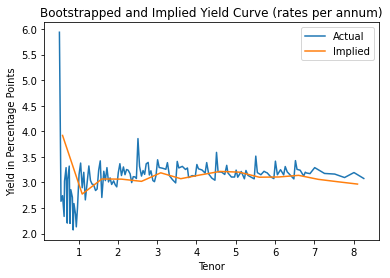

In [15]:
'''
Presents implied and actual yield curve as a plot
'''
shadow_ttm = ((shadow_px.index - datetime.datetime.now()) / datetime.timedelta(days=365)).to_list()
shadow_factors = shadow_px['shadow price'].to_list()
implied_rates = [-np.log(shadow_factors[i]) / shadow_ttm[i] for i in range(len(shadow_ttm))]

implied_rates_df = pd.DataFrame(
                        data = [shadow_ttm, implied_rates],
                        index=['ttm','implied_rate']
                    )

implied_rates_df = (implied_rates_df
                        .transpose()
                        .round({'ttm':round_to})
                        .set_index('ttm')
                    )

plt.plot(rates[0.5:8.5] * 100)
plt.plot(implied_rates_df * 100)
plt.title('Bootstrapped and Implied Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')
plt.legend(['Actual', 'Implied'])

In [16]:
'''

'''

md(''' 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

{}

'''.format((implied_rates_df*100).to_markdown(colalign = ("right",)))
)

 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

|   ttm |   implied_rate |
|------:|---------------:|
|  0.59 |        3.91856 |
|  1.09 |        2.77216 |
|  1.59 |        3.06706 |
|  2.09 |        3.06374 |
|   2.6 |        3.02059 |
|  3.09 |        3.18758 |
|   3.6 |        3.0724  |
|  4.09 |        3.14527 |
|   4.6 |        3.2145  |
|  5.09 |        3.20048 |
|   5.6 |        3.10144 |
|   6.1 |        3.10618 |
|   6.6 |        3.13822 |
|   7.1 |        3.05999 |
|   7.6 |        3.01254 |
|   8.1 |        2.96721 |



## Problem 5

Formulate a linear programming model to find the lowest cost bond immunized portfolio that matches the present value, duration, and convexity of a stream of liabilities. Assume that no short rates are allowed. What is the cost of your portfolio? How much would you save by using this immunization strategy instead of the dedication one? Is your portfolio immunized against non-parallel shifts in the term structure? Explain why or why not.

In [17]:
'''
Aggregates cashflow matrix and ref data for immunization
---
Puts cashflow matrix into a dataframe for merging
merges possible bond ref data with cashflow matrix
cleans resulting dataframe

NOTE: MATH NEEDS WORK HERE BUT WE CAN FIGURE OUT
from here: use ttm and col_num against calculated curve to find appropriate measure
        pv_factor = exp{-rt} = exp{- () * (ttm)}
'''
cf_df = pd.DataFrame(cf_matrix, index=reversed(dec_var_names.to_list()))

cf_df = pd.merge(                                                           # Combines possible bonds with cashflow matrix
    left = possibilities,                                                   # possible bonds - SAME DF AS DEDICATION
    right = cf_df,                                                          # Cashflow matrix - NP ARRAY FROM DEDICATION AS DF FOR MERGING
    how='inner',                                                            # Catches any missed bonds on merge
    left_on='ref_data',                                                     # possibilities not indexed by bond name - CHAZ IS THIS SOMETHING WE CAN ADJUST OR NO?????????????????????
    right_index=True                                                        # Casflow df indexed by bond name
)

cf_df = (cf_df
            .drop(['COUPON','period','face'],axis=1)                        # Drops unnecessary ref data
            .set_index('ref_data')                                          # Sets index to bond name
            .round({'ttm':round_to})                                        # rounds time to maturity to 2 decimal places -- allows use of derived term structure (indexed by hundredths)
        )

cf_df

,px_last,ttm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ref_data,,,,,,,,,,,,,,,,,,
T 0.0 05/05/22,99.942,-0.02,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/10/22,99.925,-0.01,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/12/22,99.857,-0.00,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 1.75 05/15/22,100.024,0.01,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 2.125 05/15/22,100.030,0.01,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T 6.125 08/15/29,120.100,7.26,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,103.0625,0.0000
T 1.75 11/15/29,91.182,7.52,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,100.8750,0.0000
T 1.5 02/15/30,89.186,7.77,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,100.7500


In [18]:
'''
Create PResent Value, Duration, and Convexity factors for all possible time index based on derived rates curve
'''
t = rates.index
r = rates['rate']
npv_factor = np.exp(-r*t)
dur_factor = (t / (1+r)) * np.exp(-r*t)
con_factor = ((t*(t+1))/ (1+r)**2) * np.exp(-r*t)

In [19]:
'''
Calculates npv, duration, and convexity terms for all bonds consiuder in problem
'''
npvs=[]
durs=[]
cons=[]
for bond in cf_df.index:
    bond_df = cf_df.loc[bond]
    bond_ttm = bond_df.loc['ttm']
    bond_cf_stream = bond_df.loc[0:]
    eo_cfs = bond_cf_stream.idxmax()
    cpn_ttm = [(bond_ttm - 0.5*i).round(round_to) for i in range(eo_cfs+1)]
    bond_cf_ttm = pd.Series(data=bond_df.loc[0:eo_cfs].to_list(), index=reversed(cpn_ttm))

    bond_npv = sum([bond_cf_ttm.loc[i] * npv_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_dur = sum([bond_cf_ttm.loc[i] * dur_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_con = sum([bond_cf_ttm.loc[i] * con_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])

    npvs.append(bond_npv)
    durs.append(bond_dur)
    cons.append(bond_con)

immunization_df = pd.DataFrame([npvs, durs, cons], columns=cf_df.index, index=['npv','duration','convexity']).transpose()

In [20]:
'''
Solves immunization portfolio
'''
bond_count = LpVariable.dicts('Bonds',dec_var_names,lowBound=0)

immunization = LpProblem('immunization', LpMinimize)

immunization += lpSum([cf_df['px_last'].loc[i] * bond_count[i] for i in dec_var_names])
immunization += lpSum([immunization_df['npv'].loc[i] * bond_count[i] for i in dec_var_names]) == npv
immunization += lpSum([immunization_df['duration'].loc[i] * bond_count[i] for i in dec_var_names]) == dur
immunization += lpSum([immunization_df['convexity'].loc[i] * bond_count[i] for i in dec_var_names]) == con

immunization.solve()

1

In [21]:
'''
Print Solution to Immunized portfolio
'''
bonds_fin = pd.DataFrame([[v.name[6:] for v in immunization.variables()], [v.varValue for v in immunization.variables()]], index=['bond','amt']).transpose().set_index('bond')
bonds_fin[bonds_fin['amt']>0]

md(''' 
##### <center> Portoflio Allocation - Immunization  </center>

<center> Immunized Portfolio Value of ${:.2f} MM  </center> <br>


<center>

{}

'''.format(value(immunization.objective) / 1000, bonds_fin[bonds_fin['amt']>0].to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Immunization  </center>

<center> Immunized Portfolio Value of $116.39 MM  </center> <br>


<center>

|             bond |     amt |
|-----------------:|--------:|
|   T_1.5_02_15_30 | 135.679 |
| T_6.625_02_15_27 | 801.824 |
|  T_7.25_08_15_22 | 117.052 |



## Problem 6

Combine a cash matching strategy (dedication) for the liabilities for the first three years and an immunization strategy based on matching present value, duration and convexity for the liabilities during the last five years. Compare the characteristics of the three bond portfolios you have obtained. Explain which one you think is the best one and why.

In [22]:
'''
code block
'''

'\ncode block\n'

## Problem 7

The municipality would like to make a second bid (find a different portfolio of bonds). What is your best dedicated portfolio of risk-free bonds you can create *if short sales are allowed*? Did you find arbitrage opportunities? Did you take into consideration the bid-ask spread of the bonds? How would you take them in consideration and what is the result? Did you set limits in the transaction amounts? Discuss the practical feasibility of your solutions.

In [23]:
'''
code block
'''

'\ncode block\n'

## Problem 8

Consider proposing a new portfolio of bonds using any additional consideration or change to the model that you see fit. For example, can you do something to make your portfolio of bonds immune to nonparallel changes in the term structure. Is there a better way to combine the techniques you used before. Explain clearly what you do and your results.

In [24]:
'''
code block
'''

'\ncode block\n'